In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
# z-dim = 100
# img-dim = 28*28
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(100, 128),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Linear(256, 28*28),
        nn.Tanh()
    )

  def forward(self,x):
    return self.net(x)

In [ ]:
# img-dim = 28*28
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(28*28, 256),
        nn.LeakyReLU(0.1),
        nn.Linear(256, 128),
        nn.LeakyReLU(0.1),
        nn.Linear(128, 1)
    )

  def forward(self,x):
    return self.net(x)

In [ ]:
device = torch.device("cuda")
G = Generator().to(device)
D = Discriminator().to(device)

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.zeros_(m.bias)

G.apply(weights_init)
D.apply(weights_init)

Discriminator(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
G_optimizer = optim.Adam(G.parameters(), lr = 0.0002)
D_optimizer = optim.Adam(D.parameters(), lr = 0.0002)

In [ ]:
!pip install torchvision matplotlib

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(
    root = './data',
    train = True,
    download = True,
    transform = tf
)

dataloader = DataLoader(
    train_dataset,
    batch_size = 64,
    shuffle = True
)

In [ ]:
print(f"Number of images: {len(train_dataset)}")
print(f"Number of batches: {len(dataloader)}")

data_iter = iter(dataloader)
real_images, labels = next(data_iter)

print(f"Batch shape: {real_images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Pixel value range: [{real_images.min():.2f}, {real_images.max():.2f}]")
print(f"First 10 labels: {labels[:10].tolist()}")

Number of images: 60000
Number of batches: 938
Batch shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])
Pixel value range: [-1.00, 1.00]
First 10 labels: [3, 1, 4, 0, 9, 8, 2, 3, 9, 5]


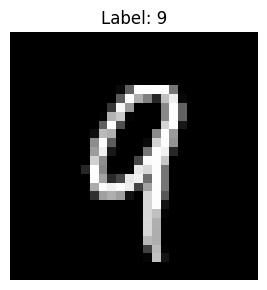

In [ ]:

fig, axes = plt.subplots(figsize=(12, 3))
img = real_images[10].squeeze()
axes.imshow(img, cmap='gray')
axes.set_title(f"Label: {labels[10].item()}")
axes.axis('off')
plt.tight_layout()
plt.show()

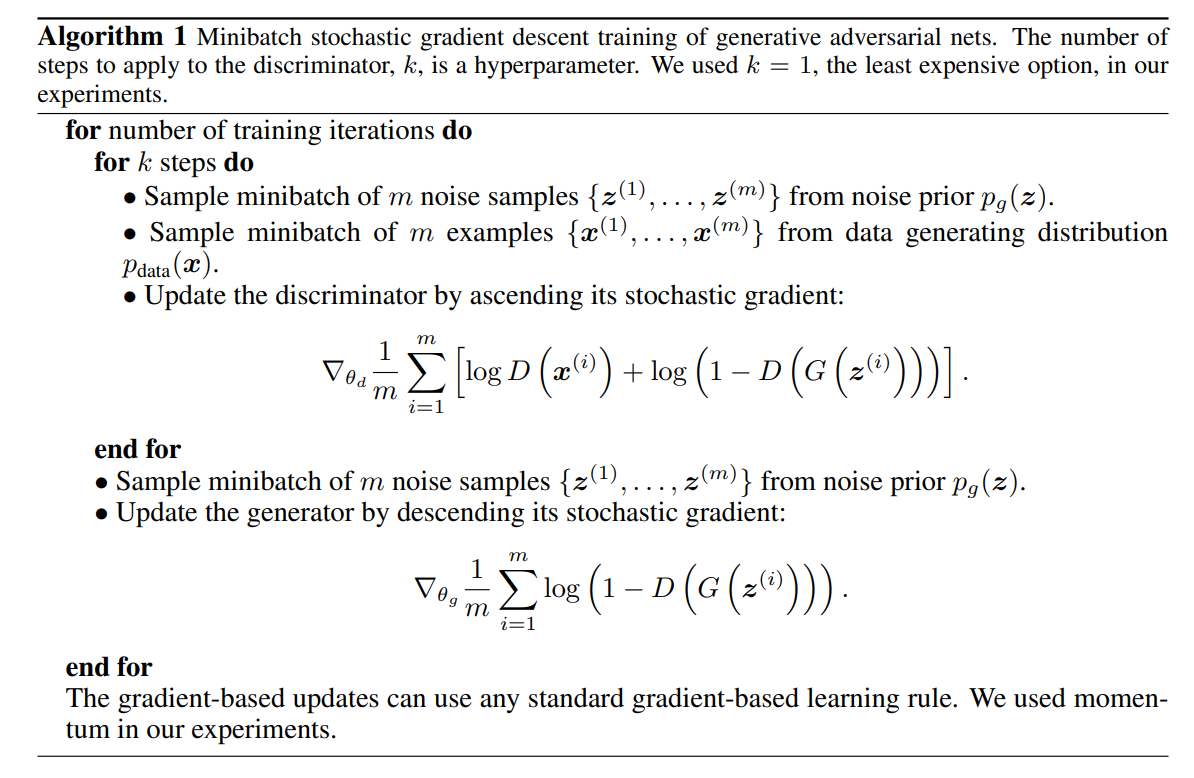

In [ ]:
from torch.cuda import device_count
for epoch in range(50):
  for batch_idx, (real_images, _) in enumerate(dataloader):

    batch_size = real_images.size(0)
    real_images = real_images.view(batch_size, -1).to(device)
    real_labels = (torch.ones(batch_size, 1) * 0.9).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Train Discriminator
    noise = torch.randn(batch_size, 100).to(device)
    fake_images = G(noise)
    D_real = D(real_images)
    D_fake = D(fake_images.detach())
    D_loss = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)
    D_optimizer.zero_grad()
    D_loss.backward()
    D_optimizer.step()

    # Train Generator
    noise = torch.randn(batch_size, 100).to(device)
    fake_images = G(noise)
    G_loss = criterion(D(fake_images), real_labels)
    G_optimizer.zero_grad()
    G_loss.backward()
    G_optimizer.step()

  if epoch % 10 == 0:
    print(f"Epoch {epoch} | D loss: {D_loss.item():.4f} | G loss: {G_loss.item():.4f}")

Epoch 0 | D loss: 0.5773 | G loss: 1.8819
Epoch 10 | D loss: 0.5843 | G loss: 3.2740
Epoch 20 | D loss: 0.7777 | G loss: 2.2721
Epoch 30 | D loss: 0.8038 | G loss: 2.1509
Epoch 40 | D loss: 0.9110 | G loss: 2.6815


In [ ]:
torch.save({
    "D": D.state_dict(),
    "G": G.state_dict(),
    "D_opt": D_optimizer.state_dict(),
    "G_opt": G_optimizer.state_dict()
}, "gan_checkpoint.pth")

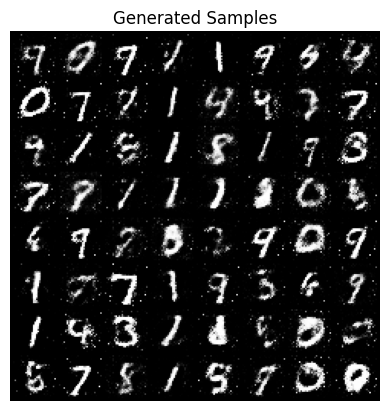

In [ ]:
from torchvision.utils import make_grid

with torch.no_grad():
    z = torch.randn(64, 100).to(device)
    samples = G(z).view(-1, 1, 28, 28)
    grid = make_grid(samples, nrow=8, normalize=True)
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.title("Generated Samples")
    plt.axis('off')
    plt.savefig("./GAN_generated_digits.png")
    plt.show()